# Airbnb Profitability Function

The purpose is to create a function to estimate if it is profitable for a existing or perspective homeowner to invest in a property to Airbnb. 

Effectively, the forumla will take this form:

        Profit = Airbnb Revenue - Mortgage Payments

Airbnb revenue and the cost of the mortgage will be calculated over a 12 month period, so profit will represent yearly profit.

Average mortgage rate for a 30-year mortgage for the state of Washington:  6.20% (as of Wednesday, September 14th, 2022)
[Source](https://www.bankrate.com/mortgages/mortgage-rates/washington/?mortgageType=Refinance&partnerId=Refinance&pid=br3&pointsChanged=false&refinanceCashOutAmount=0&refinanceLoanAmount=765600&refinanceLoanTerms=30yr%2C15yr&refinancePoints=All&refinancePropertyType=SingleFamily&refinancePropertyUse=PrimaryResidence&refinancePropertyValue=957000&searchChanged=false&showingStacked=all&ttcid&userCreditScore=740&userFha=false&userVeteranStatus=NoMilitaryService&zipCode=10270)

Average Airbnb Occupancy Rate for Seattle and its surrounding area: 67.4% 
    [Source](https://www.mashvisor.com/blog/what-airbnb-occupancy-rate-can-you-expect/)

In [53]:
avg_mortgage_rate = 0.0620
avg_airbnb_occupancy = 0.674

Load in Airbnb Average Price and House Price data based on Seattle zipcode

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from   sklearn.linear_model import LinearRegression
from   sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [55]:
df = pd.read_excel('/Users/weatherford/Documents/Flatiron/Phase_2_Housing_Project/data/king_county_home_sales.xlsx')

In [56]:
df

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_lot15,renovated,view_ord,condition_ord,grade_ord,age,point,distance_to_starbucks_miles,distance_to_amazon_miles,distance_to_needle_miles
0,0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,0,...,5650,0,0,2,4,60,"(47.5112, -122.257)",6.041009,8.552873,8.697321
1,1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0,...,7639,1,0,2,4,64,"(47.5112, -122.257)",6.041009,8.552873,8.697321
2,2,5631500400,2015-02-25,180000,2,1.00,770,10000,1.0,0,...,8062,0,0,2,3,82,"(47.721, -122.319)",9.717661,6.846950,7.085697
3,3,2487200875,2014-12-09,604000,4,3.00,1960,5000,1.0,0,...,5000,0,0,4,4,50,"(47.7379, -122.233)",11.858223,9.319655,9.758480
4,4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0,...,7503,0,0,2,5,28,"(47.5208, -122.393)",4.945854,7.509964,7.184440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21592,263000018,2014-05-21,360000,3,2.50,1530,1131,3.0,0,...,1509,0,0,2,5,6,"(47.5773, -122.409)",3.456165,4.604793,4.085285
21593,21593,6600060120,2015-02-23,400000,4,2.50,2310,5813,2.0,0,...,7200,0,0,2,5,1,"(47.6993, -122.346)",8.204234,5.315147,5.446183
21594,21594,1523300141,2014-06-23,402101,2,0.75,1020,1350,2.0,0,...,2007,0,0,2,4,6,"(47.5107, -122.362)",4.999896,7.821711,7.608764
21595,21595,291310100,2015-01-16,400000,3,2.50,1600,2388,2.0,0,...,1287,0,0,2,5,11,"(47.5944, -122.299)",1.938102,2.628624,2.962102


In [57]:
len(df['zipcode'].unique())

70

In [58]:
seattle_df = pd.read_csv('/Users/weatherford/Documents/Flatiron/Phase_2_Housing_Project/data/seattle.csv')
seattle_df = seattle_df.drop(columns= 'Unnamed: 0')
seattle_df

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,renov_yr_clean,view_ord,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,1180,0.0,...,1955.0,0.0,2.0,4.0,60,7.345680e+16,47.500403,-122.243751,170.121951,221900.0
1,4060000240,2014-06-23,2,1.00,880,6780,1.0,0,880,0.0,...,1945.0,0.0,3.0,3.0,70,7.345680e+16,47.500403,-122.243751,170.121951,205425.0
2,4058801670,2014-07-17,3,2.25,2100,8201,1.0,0,1620,480.0,...,1967.0,2.0,2.0,5.0,48,7.345680e+16,47.500403,-122.243751,170.121951,445000.0
3,2976800796,2014-09-25,3,1.00,1300,5898,1.0,0,1300,0.0,...,1961.0,0.0,2.0,4.0,54,7.345680e+16,47.500403,-122.243751,170.121951,236000.0
4,6874200960,2015-02-27,2,1.00,860,5265,1.0,0,860,0.0,...,1931.0,0.0,2.0,3.0,84,7.345680e+16,47.500403,-122.243751,170.121951,170000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,2895800590,2014-10-20,5,2.50,2170,2752,2.0,0,2170,0.0,...,2014.0,0.0,2.0,5.0,1,6.652046e+16,47.541882,-122.358118,176.106557,359800.0
9352,3438503021,2014-11-05,3,2.50,2430,7049,2.0,0,2430,0.0,...,2007.0,0.0,2.0,5.0,8,6.652046e+16,47.541882,-122.358118,176.106557,443000.0
9353,880000205,2014-07-29,3,2.00,1260,1125,2.0,0,810,450.0,...,2011.0,0.0,2.0,4.0,4,6.652046e+16,47.541882,-122.358118,176.106557,249000.0
9354,3438501329,2014-05-20,2,2.50,1590,2656,2.0,0,1220,370.0,...,2009.0,0.0,2.0,4.0,6,6.652046e+16,47.541882,-122.358118,176.106557,305000.0


In [61]:
len(seattle_df.zipcode.unique())

28

In [62]:
airbnb_revenue = seattle_df['airbnb_avg_price'] * (365) * avg_airbnb_occupancy
airbnb_revenue


0       41851.70122
1       41851.70122
2       41851.70122
3       41851.70122
4       41851.70122
           ...     
9351    43323.97418
9352    43323.97418
9353    43323.97418
9354    43323.97418
9355    43323.97418
Name: airbnb_avg_price, Length: 9356, dtype: float64

Mortgage Cost

$$Mortgage Cost = P  \frac{r(1+ r)^{n}}{ (1+r)^{n} - 1}$$

Where P equals housing price, r equals the interest rate, and n equals the number of payments over the duration of the loan


For our particular model:
- r = 6.20%
- n = 30, as we are calculating yearly mortgage cost for a 30 year mortgage
- P is each house's sale price from the Seattle subset of the King County dataset


In [63]:
seattle_df.columns

Index(['id_x', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renov_yr_clean', 'view_ord', 'condition_ord', 'grade_ord', 'age',
       'id_y', 'latitude', 'longitude', 'airbnb_avg_price', 'house_price'],
      dtype='object')

In [64]:
len(seattle_df['zipcode'].unique())

28

In [65]:
360000 * (avg_mortgage_rate * (1+avg_mortgage_rate)**30)/(((1+0.062)**30-1)) #Test of the formula

26715.736475425732

In [66]:
annual_mortgage = seattle_df['house_price'] * (avg_mortgage_rate * (1+avg_mortgage_rate)**30)/((1+0.062)**30-1)
annual_mortgage

0       16467.283122
1       15244.667126
2       33023.618699
3       17513.649467
4       12615.764447
            ...     
9351    26700.894400
9352    32875.197941
9353    18478.384396
9354    22634.165625
9355    24489.425102
Name: house_price, Length: 9356, dtype: float64

In [67]:
profit = airbnb_revenue - annual_mortgage
profit
profit.describe()

count      9356.000000
mean       3535.502767
std       26754.896935
min     -520122.866154
25%       -3815.995545
50%        7623.692286
75%       16620.808922
max       82840.189344
dtype: float64

In [68]:
seattle_df['profit'] = profit
seattle_df

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,view_ord,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,1180,0.0,...,0.0,2.0,4.0,60,7.345680e+16,47.500403,-122.243751,170.121951,221900.0,25384.418098
1,4060000240,2014-06-23,2,1.00,880,6780,1.0,0,880,0.0,...,0.0,3.0,3.0,70,7.345680e+16,47.500403,-122.243751,170.121951,205425.0,26607.034093
2,4058801670,2014-07-17,3,2.25,2100,8201,1.0,0,1620,480.0,...,2.0,2.0,5.0,48,7.345680e+16,47.500403,-122.243751,170.121951,445000.0,8828.082521
3,2976800796,2014-09-25,3,1.00,1300,5898,1.0,0,1300,0.0,...,0.0,2.0,4.0,54,7.345680e+16,47.500403,-122.243751,170.121951,236000.0,24338.051752
4,6874200960,2015-02-27,2,1.00,860,5265,1.0,0,860,0.0,...,0.0,2.0,3.0,84,7.345680e+16,47.500403,-122.243751,170.121951,170000.0,29235.936773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,2895800590,2014-10-20,5,2.50,2170,2752,2.0,0,2170,0.0,...,0.0,2.0,5.0,1,6.652046e+16,47.541882,-122.358118,176.106557,359800.0,16623.079781
9352,3438503021,2014-11-05,3,2.50,2430,7049,2.0,0,2430,0.0,...,0.0,2.0,5.0,8,6.652046e+16,47.541882,-122.358118,176.106557,443000.0,10448.776240
9353,880000205,2014-07-29,3,2.00,1260,1125,2.0,0,810,450.0,...,0.0,2.0,4.0,4,6.652046e+16,47.541882,-122.358118,176.106557,249000.0,24845.589785
9354,3438501329,2014-05-20,2,2.50,1590,2656,2.0,0,1220,370.0,...,0.0,2.0,4.0,6,6.652046e+16,47.541882,-122.358118,176.106557,305000.0,20689.808555


In [69]:
seattle_df["profitable?"]= np.where(seattle_df['profit']>0, 1, 0)
seattle_df

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,1180,0.0,...,2.0,4.0,60,7.345680e+16,47.500403,-122.243751,170.121951,221900.0,25384.418098,1
1,4060000240,2014-06-23,2,1.00,880,6780,1.0,0,880,0.0,...,3.0,3.0,70,7.345680e+16,47.500403,-122.243751,170.121951,205425.0,26607.034093,1
2,4058801670,2014-07-17,3,2.25,2100,8201,1.0,0,1620,480.0,...,2.0,5.0,48,7.345680e+16,47.500403,-122.243751,170.121951,445000.0,8828.082521,1
3,2976800796,2014-09-25,3,1.00,1300,5898,1.0,0,1300,0.0,...,2.0,4.0,54,7.345680e+16,47.500403,-122.243751,170.121951,236000.0,24338.051752,1
4,6874200960,2015-02-27,2,1.00,860,5265,1.0,0,860,0.0,...,2.0,3.0,84,7.345680e+16,47.500403,-122.243751,170.121951,170000.0,29235.936773,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,2895800590,2014-10-20,5,2.50,2170,2752,2.0,0,2170,0.0,...,2.0,5.0,1,6.652046e+16,47.541882,-122.358118,176.106557,359800.0,16623.079781,1
9352,3438503021,2014-11-05,3,2.50,2430,7049,2.0,0,2430,0.0,...,2.0,5.0,8,6.652046e+16,47.541882,-122.358118,176.106557,443000.0,10448.776240,1
9353,880000205,2014-07-29,3,2.00,1260,1125,2.0,0,810,450.0,...,2.0,4.0,4,6.652046e+16,47.541882,-122.358118,176.106557,249000.0,24845.589785,1
9354,3438501329,2014-05-20,2,2.50,1590,2656,2.0,0,1220,370.0,...,2.0,4.0,6,6.652046e+16,47.541882,-122.358118,176.106557,305000.0,20689.808555,1


In [70]:
seattle_df.loc[seattle_df.profit < 0]

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
18,7567600045,2014-08-27,2,1.00,1150,12775,1.0,1,1150,0.0,...,3.0,3.0,107,7.345680e+16,47.500403,-122.243751,170.121951,825000.0,-19371.861537,0
21,8069000075,2014-12-29,4,1.75,2460,10061,1.0,1,1410,1050.0,...,2.0,4.0,54,7.345680e+16,47.500403,-122.243751,170.121951,790000.0,-16774.498268,0
24,8073000550,2015-04-15,4,3.75,3190,17186,2.0,1,3190,0.0,...,2.0,7.0,16,7.345680e+16,47.500403,-122.243751,170.121951,1700000.0,-84305.943248,0
25,4058800830,2015-03-18,6,3.00,3840,14040,1.5,0,2460,1380.0,...,2.0,5.0,66,7.345680e+16,47.500403,-122.243751,170.121951,612000.0,-3565.050789,0
46,8073000495,2014-10-10,2,1.00,1160,17635,1.0,1,1160,0.0,...,2.0,3.0,70,7.345680e+16,47.500403,-122.243751,170.121951,700000.0,-10095.564149,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9063,8941800100,2015-04-27,3,3.25,3870,11000,2.0,0,2970,900.0,...,2.0,6.0,24,6.652046e+16,47.541882,-122.358118,176.106557,645000.0,-4541.720338,0
9266,3438502290,2015-02-02,3,1.50,2140,47743,1.5,0,2140,0.0,...,2.0,6.0,37,6.652046e+16,47.541882,-122.358118,176.106557,616750.0,-2445.277129,0
9303,1772600510,2014-06-20,3,2.50,2440,4800,2.0,0,2440,0.0,...,2.0,7.0,1,6.652046e+16,47.541882,-122.358118,176.106557,625000.0,-3057.512756,0
9328,3438500253,2014-09-04,5,3.50,3560,5008,2.0,0,2810,750.0,...,2.0,5.0,2,6.652046e+16,47.541882,-122.358118,176.106557,616950.0,-2460.119204,0


## EDA for profit to see what the primary drivers are

Hypothesis: probably largely linked to the drivers of price

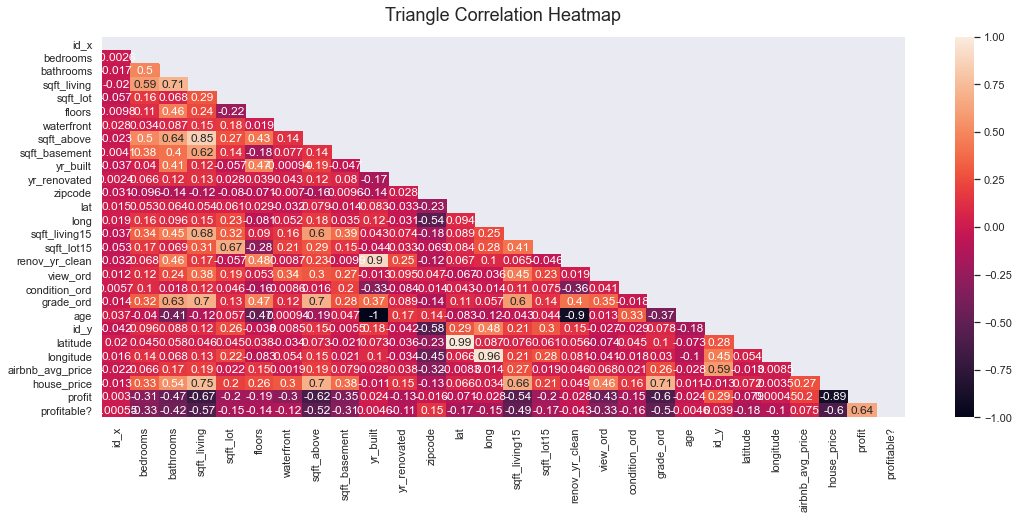

In [71]:
plt.figure(figsize=(18,7))
mask = np.triu(np.ones_like(seattle_df.corr(), dtype=bool))
heatmap = sns.heatmap(seattle_df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show();

<AxesSubplot:>

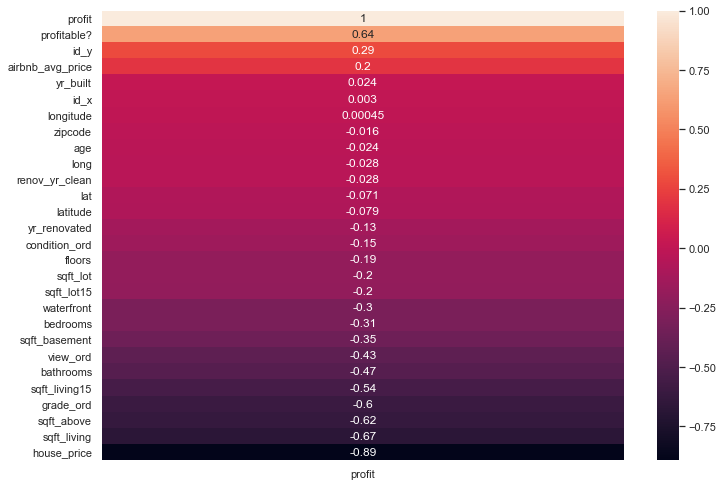

In [72]:
corr = seattle_df.corr()[['profit']].sort_values(by='profit', ascending=False)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr, annot=True)

# Visualizations for Square Foot of Living Area's effect on profit and house price

Since profit is depending on house price (the more a house's mortgage costs, the less profitable renting it out will be for a set revenue), square foot of the living area is positively correlated with price and negatively correlated with profit.

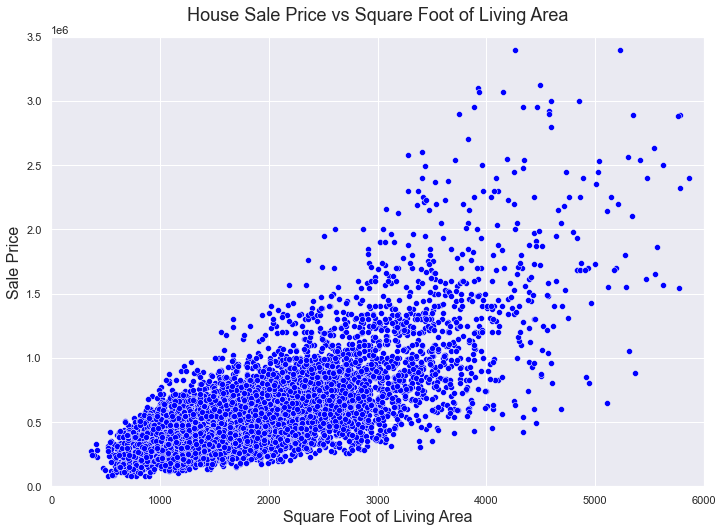

In [137]:
fig, ax = plt.subplots()
sns.scatterplot(data= seattle_df, x="sqft_living", y="house_price", ax=ax, color = "blue")
ax.set_xlim(0, 6000)
ax.set_ylim(0, 3500000)
ax.set_title('House Sale Price vs Square Foot of Living Area', fontdict={'fontsize':18}, pad=16)
ax.set_xlabel('Square Foot of Living Area', fontdict={'fontsize':16})
ax.set_ylabel('Sale Price', fontdict={'fontsize':16})
plt.show()
fig.savefig('sale_price_vs_sqft_living.png');

In [74]:
seattle_df.columns

Index(['id_x', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renov_yr_clean', 'view_ord', 'condition_ord', 'grade_ord', 'age',
       'id_y', 'latitude', 'longitude', 'airbnb_avg_price', 'house_price',
       'profit', 'profitable?'],
      dtype='object')

In [75]:
#most profitable zip code
kenmore = seattle_df.loc[seattle_df['zipcode'] == 98028]
print("avgerage price per home for 98028: ", kenmore['house_price'].mean())

#2nd most profitable zip code
df1 = seattle_df.loc[seattle_df['zipcode'] == 98106]
print("avgerage price per home for 98106: ", df1['house_price'].mean())

#3rd most profitable zip code
df2 = seattle_df.loc[seattle_df['zipcode'] == 98168]
print("avgerage price per home for 98168: ", df2['house_price'].mean())

avgerage price per home for 98028:  462488.8692579505
avgerage price per home for 98106:  319581.3940298507
avgerage price per home for 98168:  240328.3717472119


In [76]:
kenmore.sort_values(by=['profit'], ascending = False)

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
837,4140900270,2015-04-27,2,1.00,1140,23030,1.0,0,1140,0.0,...,2.0,5.0,35,5.829030e+17,47.74011,-122.26517,385.0,160000.0,82840.189344,1
671,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,770,0.0,...,2.0,3.0,82,5.829030e+17,47.74011,-122.26517,385.0,180000.0,81355.981762,1
835,2570600140,2015-01-28,3,2.25,1510,9600,1.0,0,1090,420.0,...,0.0,4.0,49,5.829030e+17,47.74011,-122.26517,385.0,196000.0,80168.615697,1
816,9406500350,2014-12-29,2,1.50,1068,1158,2.0,0,1068,0.0,...,2.0,4.0,25,5.829030e+17,47.74011,-122.26517,385.0,207000.0,79352.301527,1
694,4027701275,2014-07-18,3,1.00,1240,6195,1.0,0,1240,0.0,...,2.0,3.0,67,5.829030e+17,47.74011,-122.26517,385.0,230000.0,77645.462807,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1426049083,2014-10-22,3,2.50,2760,11287,2.0,0,2000,760.0,...,2.0,7.0,24,5.829030e+17,47.74011,-122.26517,385.0,830000.0,33119.235348,1
706,7018000560,2015-04-20,4,4.25,3770,13058,2.0,0,3770,0.0,...,3.0,5.0,32,5.829030e+17,47.74011,-122.26517,385.0,925000.0,26069.249334,1
878,3582900280,2014-06-06,5,2.75,4400,18500,1.0,0,2250,2150.0,...,4.0,6.0,52,5.829030e+17,47.74011,-122.26517,385.0,1120000.0,11598.225410,1
843,5634500688,2015-03-25,6,3.25,3870,24700,2.0,0,2520,1350.0,...,2.0,7.0,26,5.829030e+17,47.74011,-122.26517,385.0,1130000.0,10856.121619,1


In [77]:
kenmore.columns

Index(['id_x', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renov_yr_clean', 'view_ord', 'condition_ord', 'grade_ord', 'age',
       'id_y', 'latitude', 'longitude', 'airbnb_avg_price', 'house_price',
       'profit', 'profitable?'],
      dtype='object')

In [78]:
sns.set_palette("mako")

In [79]:
df1.sort_values(by=['profit'], ascending = False)

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
9251,2114700500,2015-04-18,1,1.00,560,4120,1.0,0,560,0.0,...,2.0,1.0,68,6.652046e+16,47.541882,-122.358118,176.106557,90000.0,36645.040061,1
9216,123039604,2014-07-01,2,1.00,820,4320,1.0,0,820,0.0,...,2.0,2.0,78,6.652046e+16,47.541882,-122.358118,176.106557,102500.0,35717.410323,1
9191,7899800045,2014-08-28,3,1.50,910,5120,1.0,0,910,0.0,...,2.0,3.0,42,6.652046e+16,47.541882,-122.358118,176.106557,107000.0,35383.463617,1
9128,7899800450,2014-08-28,2,1.00,670,4720,1.0,0,670,0.0,...,3.0,3.0,67,6.652046e+16,47.541882,-122.358118,176.106557,107000.0,35383.463617,1
9074,859000110,2014-10-02,1,1.00,500,7440,1.0,0,500,0.0,...,0.0,2.0,87,6.652046e+16,47.541882,-122.358118,176.106557,125000.0,34047.676793,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9328,3438500253,2014-09-04,5,3.50,3560,5008,2.0,0,2810,750.0,...,2.0,5.0,2,6.652046e+16,47.541882,-122.358118,176.106557,616950.0,-2460.119204,0
9303,1772600510,2014-06-20,3,2.50,2440,4800,2.0,0,2440,0.0,...,2.0,7.0,1,6.652046e+16,47.541882,-122.358118,176.106557,625000.0,-3057.512756,0
9063,8941800100,2015-04-27,3,3.25,3870,11000,2.0,0,2970,900.0,...,2.0,6.0,24,6.652046e+16,47.541882,-122.358118,176.106557,645000.0,-4541.720338,0
9347,1773600264,2015-02-23,5,3.50,3250,4800,2.0,0,2410,840.0,...,2.0,6.0,5,6.652046e+16,47.541882,-122.358118,176.106557,705000.0,-8994.343084,0


In [80]:
df2.sort_values(by=['profit'], ascending = False)

,id_x,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
8139,40000362,2014-05-06,2,1.0,780,16344,1.0,0,780,0.0,...,0.0,2.0,73,1.733117e+17,47.500964,-122.310838,155.425926,78000.0,32447.922467,1
8150,3028200080,2015-03-24,2,1.0,730,9975,1.0,0,730,0.0,...,0.0,2.0,72,1.733117e+17,47.500964,-122.310838,155.425926,81000.0,32225.291330,1
7968,1623049041,2014-05-08,2,1.0,520,22334,1.0,0,520,0.0,...,1.0,2.0,64,1.733117e+17,47.500964,-122.310838,155.425926,82500.0,32113.975761,1
8192,7999600180,2014-05-29,2,1.0,900,8580,1.0,0,900,0.0,...,2.0,2.0,97,1.733117e+17,47.500964,-122.310838,155.425926,83000.0,32076.870572,1
7993,1523049188,2015-04-30,2,1.0,700,20130,1.0,0,700,0.0,...,2.0,3.0,66,1.733117e+17,47.500964,-122.310838,155.425926,84000.0,32002.660193,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8084,2612000200,2015-04-27,3,2.5,2050,8172,2.0,0,2050,0.0,...,2.0,5.0,13,1.733117e+17,47.500964,-122.310838,155.425926,394950.0,8926.942812,1
8077,42000127,2015-02-24,3,1.5,1970,10080,1.0,0,1970,0.0,...,2.0,4.0,49,1.733117e+17,47.500964,-122.310838,155.425926,406500.0,8069.812934,1
8189,3365900175,2015-04-02,3,2.5,1600,5960,2.0,0,1600,0.0,...,4.0,5.0,105,1.733117e+17,47.500964,-122.310838,155.425926,424305.0,6748.497134,1
8164,40000669,2015-03-19,4,2.5,2910,20067,2.0,0,2910,0.0,...,2.0,6.0,14,1.733117e+17,47.500964,-122.310838,155.425926,499950.0,1134.853007,1


In [81]:
subset = seattle_df.loc[seattle_df['airbnb_avg_price'] > 300][0:25]
subset['zipcode'].unique()

array([98028])

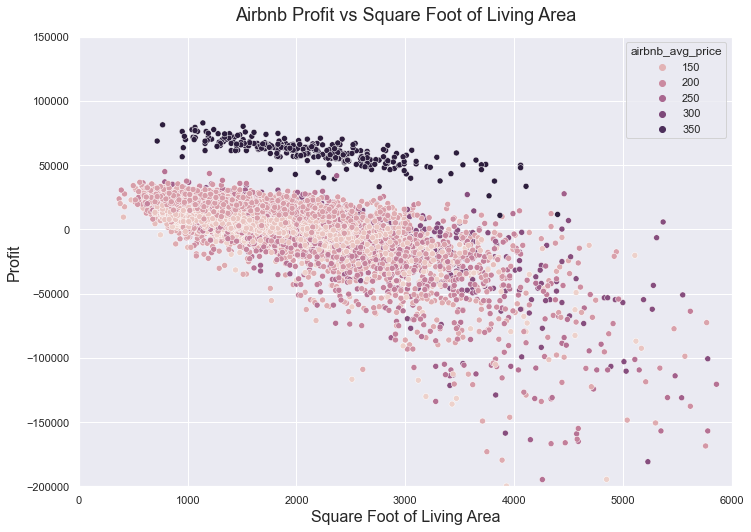

In [138]:
fig, ax = plt.subplots()
sns.scatterplot(data= seattle_df, x="sqft_living", y="profit", ax=ax, color = 'red', hue = 'airbnb_avg_price')
ax.set_xlim(0, 6000)
ax.set_ylim(-200000, 150000)
ax.set_title('Airbnb Profit vs Square Foot of Living Area', fontdict={'fontsize':18}, pad=16)
ax.set_xlabel('Square Foot of Living Area', fontdict={'fontsize':16})
ax.set_ylabel('Profit', fontdict={'fontsize':16})

plt.show()

fig.savefig('profit_vs_sqft_living.png');

In [83]:
print(kenmore['house_price'].max())
print(kenmore['house_price'].min())
kenmore['house_price'].describe()

1600000.0
160000.0


count    2.830000e+02
mean     4.624889e+05
std      1.495297e+05
min      1.600000e+05
25%      3.799750e+05
50%      4.450000e+05
75%      5.258750e+05
max      1.600000e+06
Name: house_price, dtype: float64

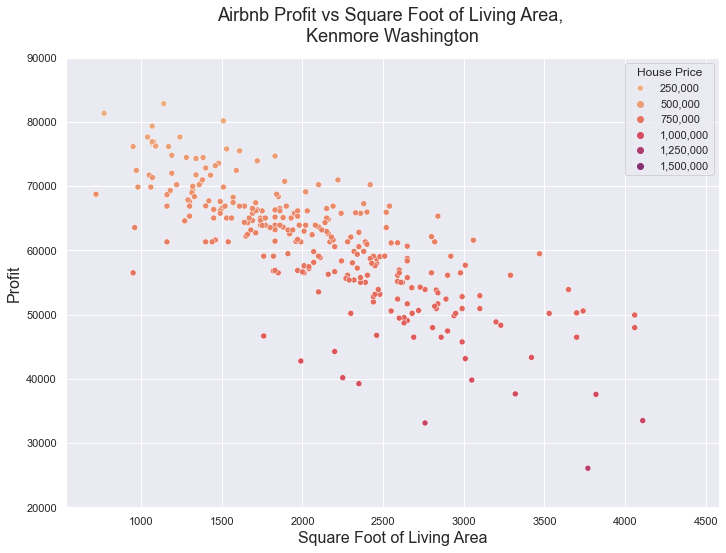

In [135]:
fig, ax = plt.subplots()
sns.scatterplot(data= kenmore, x="sqft_living", y="profit", ax=ax, hue = "house_price", legend = 'auto', palette = "flare")
#ax.set_xlim(0, 6000)
ax.set_ylim(20000, 90000)
ax.set_title('''Airbnb Profit vs Square Foot of Living Area, 
Kenmore Washington''', fontdict={'fontsize':18}, pad=16)
ax.set_xlabel('Square Foot of Living Area', fontdict={'fontsize':16})
ax.set_ylabel('Profit', fontdict={'fontsize':16})
plt.legend(title='House Price', loc='upper right', labels=['250,000', '500,000', '750,000','1,000,000','1,250,000','1,500,000'])

plt.show() 


fig.savefig('sale_price_vs_sqft_living.png');

In [130]:
X, y = seattle_df[['sqft_living']] , seattle_df[['profit']]

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=42
)

# Init, fit, score
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

print(f"Training score: {multi_model.score(X_train, y_train)}")
multi_model_score = multi_model.score(X_test, y_test)
print(f"Test score: {multi_model.score(X_test, y_test)}")

Training score: 0.43612014788921094
Test score: 0.49159056990996663


In [128]:
df1 = pd.read_excel('/Users/weatherford/Documents/Flatiron/Phase_2_Housing_Project/data/washington_state_income_by_zipcode.xlsx')

In [129]:
df1['zipcode'] = df1['Zip Code']
df1 = df1.drop(columns=['Zip Code'])
df1

,#,Location,City,Population,Avg. Income/H/hold,National Rank,zipcode
0,1,"47.626035, -122.233707","Medina, Washington",3050,132665,#46,98039
1,2,"47.655058, -122.025817","Redmond, Washington",31203,96028,#335,98053
2,3,"47.855439, -122.595728","Port Gamble, Washington",102,94366,#364,98364
3,4,"47.562356, -122.226514","Mercer Island, Washington",22036,91904,#415,98040
4,5,"47.578444, -122.013924","Issaquah, Washington",28427,91146,#430,98029
...,...,...,...,...,...,...,...
562,558,"47.251349, -122.443181","Tacoma, Washington",4935,15847,"#31,304",98402
563,559,"46.510216, -118.194986","Starbuck, Washington",72,13393,"#31,550",99359
564,560,"47.604569, -122.335359","Seattle, Washington",180,0,"#31,889",98174
565,561,"47.606211, -122.333792","Seattle, Washington",1,0,"#31,893",98154


Made dataframe including profitability data and household income data, merged on zipcode, for Seattle metro area

In [88]:
df = pd.merge(seattle_df, df1, on='zipcode', how='inner')

In [89]:
df.loc[df.bedrooms == 33]
df = df.drop(labels=3099, axis=0)

In [90]:
df.columns

Index(['id_x', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renov_yr_clean', 'view_ord', 'condition_ord', 'grade_ord', 'age',
       'id_y', 'latitude', 'longitude', 'airbnb_avg_price', 'house_price',
       'profit', 'profitable?', '#', 'Location', 'City', 'Population',
       'Avg. Income/H/hold', 'National Rank'],
      dtype='object')

In [126]:
df['Avg. Income/H/hold']

0       47461
1       47461
2       47461
3       47461
4       47461
        ...  
9351    40815
9352    40815
9353    40815
9354    40815
9355    40815
Name: Avg. Income/H/hold, Length: 9355, dtype: object

In [125]:
top_cities = df.groupby(by=['Avg. Income/H/hold']).mean()
top_cities = top_cities.sort_values(by=['profit'], ascending=False)
top_cities

,id_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
Avg. Income/H/hold,,,,,,,,,,,,,,,,,,,,,
61813,4.415451e+09,3.480565,2.143110,2122.724382,11935.374558,1.420495,0.003534,1781.098940,324.911661,1977.830389,...,2.300353,4.611307,37.169611,5.829030e+17,47.740110,-122.265170,385.000000,4.624889e+05,60392.375684,0.996466
41097,3.204785e+09,2.996283,1.433086,1468.624535,11269.843866,1.159851,0.000000,1234.089219,229.182156,1952.721190,...,2.245353,3.509294,62.278810,1.733117e+17,47.500964,-122.310838,155.425926,2.403284e+05,20401.472462,0.996283
40815,4.412164e+09,3.101493,1.804478,1487.883582,5554.238806,1.382090,0.000000,1188.271642,295.223881,1965.537313,...,2.247761,3.865672,49.462687,6.652046e+16,47.541882,-122.358118,176.106557,3.195814e+05,19607.717777,0.982090
47461,4.291467e+09,3.305344,1.731870,1729.351145,8309.122137,1.185115,0.034351,1325.992366,396.068702,1955.232824,...,2.320611,3.816794,59.767176,7.345680e+16,47.500403,-122.243751,170.121951,3.106128e+05,18801.010864,0.946565
38413,4.952066e+09,3.204301,1.931452,1704.623656,5204.844086,1.376344,0.000000,1300.268817,402.795699,1957.908602,...,2.403226,4.016129,57.091398,1.386757e+17,47.549144,-122.307968,155.711538,3.556785e+05,11911.558058,0.924731
44697,4.283876e+09,3.132150,1.765286,1689.303748,5780.185404,1.343195,0.005917,1331.015779,354.737673,1950.305720,...,2.351085,3.976331,64.694280,7.598362e+16,47.543534,-122.277837,171.003484,4.180194e+05,11047.191931,0.834320
47519,5.268250e+09,2.836158,1.678672,1543.596045,5114.610169,1.350282,0.000000,1249.019774,285.762712,1952.725989,...,2.466102,4.031073,62.274011,3.922233e+16,47.556849,-122.375475,169.449438,4.247346e+05,10166.540275,0.850282
42195,3.289489e+09,2.996241,2.045113,1579.548872,3194.368421,1.834586,0.000000,1317.218045,256.691729,1959.631579,...,2.421053,4.424812,55.368421,1.198376e+17,47.667910,-122.374809,211.581498,5.791098e+05,9075.205862,0.845865
54563,5.207714e+09,3.066667,1.987121,1853.369697,4979.421212,1.528788,0.003030,1419.642424,419.000000,1953.675758,...,2.512121,4.569697,61.324242,7.703663e+16,47.574526,-122.398955,216.022857,6.186951e+05,7230.184494,0.766667


In [124]:
top_zipcodes = df.groupby(by=['zipcode']).mean()
top_zipcodes = top_zipcodes.sort_values(by=['profit'], ascending=False)
top_zipcodes = top_zipcodes.reset_index()
top_zipcodes

,zipcode,id_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
0,98028,4.415451e+09,3.480565,2.143110,2122.724382,11935.374558,1.420495,0.003534,1781.098940,324.911661,...,2.300353,4.611307,37.169611,5.829030e+17,47.740110,-122.265170,385.000000,4.624889e+05,60392.375684,0.996466
1,98168,3.204785e+09,2.996283,1.433086,1468.624535,11269.843866,1.159851,0.000000,1234.089219,229.182156,...,2.245353,3.509294,62.278810,1.733117e+17,47.500964,-122.310838,155.425926,2.403284e+05,20401.472462,0.996283
2,98106,4.412164e+09,3.101493,1.804478,1487.883582,5554.238806,1.382090,0.000000,1188.271642,295.223881,...,2.247761,3.865672,49.462687,6.652046e+16,47.541882,-122.358118,176.106557,3.195814e+05,19607.717777,0.982090
3,98178,4.291467e+09,3.305344,1.731870,1729.351145,8309.122137,1.185115,0.034351,1325.992366,396.068702,...,2.320611,3.816794,59.767176,7.345680e+16,47.500403,-122.243751,170.121951,3.106128e+05,18801.010864,0.946565
4,98108,4.952066e+09,3.204301,1.931452,1704.623656,5204.844086,1.376344,0.000000,1300.268817,402.795699,...,2.403226,4.016129,57.091398,1.386757e+17,47.549144,-122.307968,155.711538,3.556785e+05,11911.558058,0.924731
5,98118,4.283876e+09,3.132150,1.765286,1689.303748,5780.185404,1.343195,0.005917,1331.015779,354.737673,...,2.351085,3.976331,64.694280,7.598362e+16,47.543534,-122.277837,171.003484,4.180194e+05,11047.191931,0.834320
6,98126,5.268250e+09,2.836158,1.678672,1543.596045,5114.610169,1.350282,0.000000,1249.019774,285.762712,...,2.466102,4.031073,62.274011,3.922233e+16,47.556849,-122.375475,169.449438,4.247346e+05,10166.540275,0.850282
7,98107,3.289489e+09,2.996241,2.045113,1579.548872,3194.368421,1.834586,0.000000,1317.218045,256.691729,...,2.421053,4.424812,55.368421,1.198376e+17,47.667910,-122.374809,211.581498,5.791098e+05,9075.205862,0.845865
8,98116,5.207714e+09,3.066667,1.987121,1853.369697,4979.421212,1.528788,0.003030,1419.642424,419.000000,...,2.512121,4.569697,61.324242,7.703663e+16,47.574526,-122.398955,216.022857,6.186951e+05,7230.184494,0.766667
9,98146,4.607855e+09,3.125000,1.633681,1621.451389,9020.243056,1.222222,0.020833,1374.854167,242.465278,...,2.291667,3.822917,59.208333,5.113193e+16,47.505161,-122.355293,136.758621,3.594963e+05,6965.634506,0.784722


In [116]:
sns.set_palette(sns.color_palette("hls"))

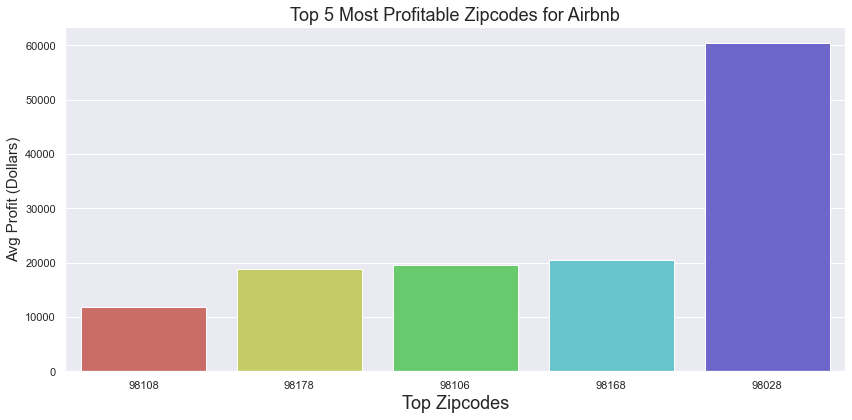

In [123]:
plt.figure(figsize=(12,6))
# make barplot and sort bars
sns.barplot(data=top_zipcodes.head(5), x="zipcode", y="profit", order=top_zipcodes.head().sort_values('profit').zipcode)   

#set labels
plt.xlabel("Top Zipcodes", size=18)
plt.ylabel("Avg Profit (Dollars)", size=15)
plt.title("Top 5 Most Profitable Zipcodes for Airbnb", size=18)
plt.tight_layout()
plt.savefig("top_5_protifable_zipcodes.png", dpi=100);



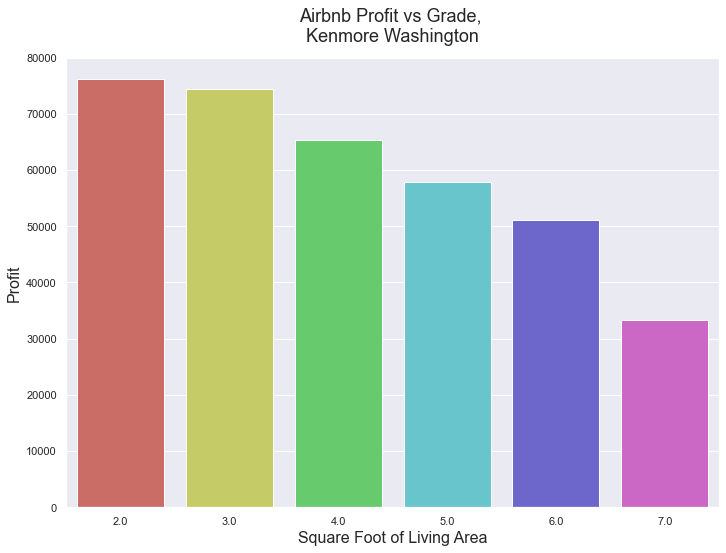

In [118]:
#bar graph to look at profit and grade of house
# as the grade of the house increases, the price goes up and profit margins begin to decline
# for rental properties

fig, ax = plt.subplots()
sns.barplot(data= kenmore, x="grade_ord", y="profit", ax=ax, estimator = np.median,ci = 0)
#ax.set_xlim(0, 6000)
ax.set_ylim(0, 80000)
ax.set_title('''Airbnb Profit vs Grade, 
Kenmore Washington''', fontdict={'fontsize':18}, pad=16)
ax.set_xlabel('Square Foot of Living Area', fontdict={'fontsize':16})
ax.set_ylabel('Profit', fontdict={'fontsize':16})

plt.show()

#fig.savefig('sale_price_vs_sqft_living.png');

In [97]:
#df.to_csv('seattle_income_&_profit.csv')

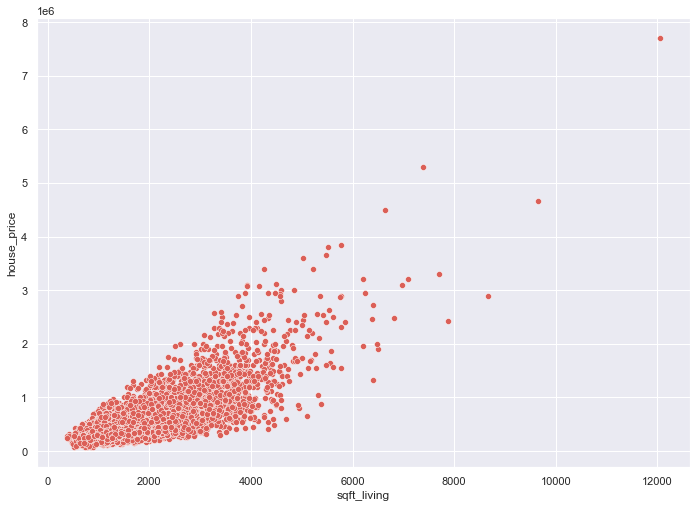

In [119]:
sns.scatterplot(data= df, x="sqft_living" , y="house_price");

In [120]:
df['grade_ord'].loc[df['house_price'] >= 5000000]

3822     9.0
7684    10.0
Name: grade_ord, dtype: float64

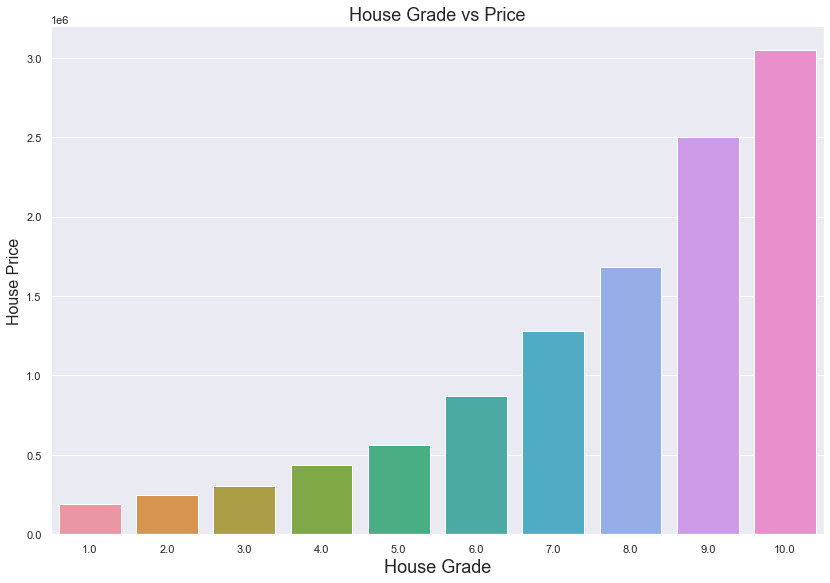

In [121]:
sns.barplot(data= df, x="grade_ord" , y="house_price", estimator = np.median,ci = 0)

plt.xlabel("House Grade", size=18)
plt.ylabel("House Price", size=16)
plt.title("House Grade vs Price", size=18)
plt.tight_layout()
plt.savefig("house_grade_barplot.png", dpi=100);

In [122]:
df.corr()

,id_x,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,...,condition_ord,grade_ord,age,id_y,latitude,longitude,airbnb_avg_price,house_price,profit,profitable?
id_x,1.000000,-0.000260,-0.016767,-0.019815,-0.057085,-0.009880,0.028319,-0.022950,-0.004087,-0.036731,...,0.005879,-0.014530,0.036731,-0.041892,0.019601,0.016237,-0.022180,-0.013160,0.002989,0.000608
bedrooms,-0.000260,1.000000,0.522452,0.623174,0.172572,0.119829,0.035684,0.526769,0.395729,0.043373,...,0.099965,0.337609,-0.043373,0.101639,0.045116,0.148317,0.068612,0.346211,-0.320114,-0.350458
bathrooms,-0.016767,0.522452,1.000000,0.713847,0.068132,0.463443,0.086985,0.637718,0.402898,0.413882,...,0.017965,0.633016,-0.413882,0.088245,0.057652,0.068034,0.167434,0.535853,-0.466738,-0.424798
sqft_living,-0.019815,0.623174,0.713847,1.000000,0.289681,0.240173,0.149265,0.852740,0.624453,0.122547,...,0.120064,0.695335,-0.122547,0.117121,0.046346,0.126992,0.192043,0.749606,-0.672705,-0.574332
sqft_lot,-0.057085,0.172572,0.068132,0.289681,1.000000,-0.223608,0.177137,0.270381,0.143605,-0.057307,...,0.045716,0.130329,0.057307,0.255013,0.045448,0.224443,0.021899,0.203178,-0.196476,-0.154434
floors,-0.009880,0.119829,0.463443,0.240173,-0.223608,1.000000,0.018918,0.433039,-0.181422,0.469206,...,-0.160757,0.466515,-0.469206,-0.038226,0.037986,-0.082781,0.148969,0.257513,-0.192169,-0.143860
waterfront,0.028319,0.035684,0.086985,0.149265,0.177137,0.018918,1.000000,0.138563,0.076582,-0.000947,...,0.008635,0.118011,0.000947,0.008528,-0.034071,0.053655,0.001893,0.299412,-0.303784,-0.117831
sqft_above,-0.022950,0.526769,0.637718,0.852740,0.270381,0.433039,0.138563,1.000000,0.136451,0.190211,...,0.016361,0.700912,-0.190211,0.152142,0.073089,0.149440,0.189249,0.699750,-0.623284,-0.521133
sqft_basement,-0.004087,0.395729,0.402898,0.624453,0.143605,-0.181422,0.076582,0.136451,1.000000,-0.046698,...,0.198616,0.278370,0.046698,-0.005516,-0.020671,0.021479,0.078785,0.383027,-0.352805,-0.314267
yr_built,-0.036731,0.043373,0.413882,0.122547,-0.057307,0.469206,-0.000947,0.190211,-0.046698,1.000000,...,-0.327540,0.368116,-1.000000,0.175156,0.072627,0.101894,0.028116,-0.010795,0.024171,0.004588


### Create a correlation heatmap based on the primary drivers of House Sale Price

In [106]:
seattle_df.columns

Index(['id_x', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'renov_yr_clean', 'view_ord', 'condition_ord', 'grade_ord', 'age',
       'id_y', 'latitude', 'longitude', 'airbnb_avg_price', 'house_price',
       'profit', 'profitable?'],
      dtype='object')

In [105]:
#first create a subset of the seattle_df with the highest correlated variables
seattle_corr = seattle_df.drop(columns= ['id_x','date',
       'floors', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_lot15',
       'renov_yr_clean', 'condition_ord', 'age',
       'id_y', 'latitude', 'longitude','airbnb_avg_price',
       'profit', 'profitable?'])
seattle_corr

,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_living15,view_ord,grade_ord,house_price
0,3,1.00,1180,5650,0,1180,1340,0.0,4.0,221900.0
1,2,1.00,880,6780,0,880,1190,0.0,3.0,205425.0
2,3,2.25,2100,8201,0,1620,2660,2.0,5.0,445000.0
3,3,1.00,1300,5898,0,1300,1320,0.0,4.0,236000.0
4,2,1.00,860,5265,0,860,1650,0.0,3.0,170000.0
...,...,...,...,...,...,...,...,...,...,...
9351,5,2.50,2170,2752,0,2170,1800,0.0,5.0,359800.0
9352,3,2.50,2430,7049,0,2430,1770,0.0,5.0,443000.0
9353,3,2.00,1260,1125,0,810,1260,0.0,4.0,249000.0
9354,2,2.50,1590,2656,0,1220,1590,0.0,4.0,305000.0


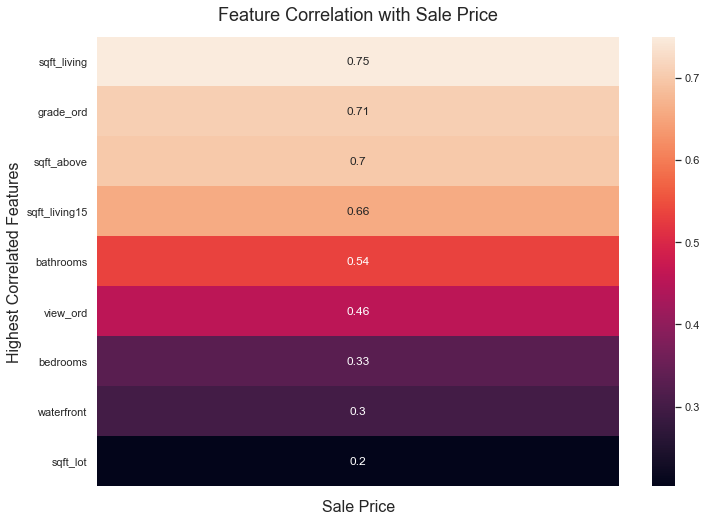

In [107]:
corr = seattle_corr.corr()[['house_price']].sort_values(by='house_price', ascending=False)
corr = corr.drop('house_price')

sns.set(rc={'figure.figsize':(11.7,8.27)})
heatmap = sns.heatmap(corr, annot=True)

heatmap.set_title('Feature Correlation with Sale Price', fontdict={'fontsize':18}, pad=16)
heatmap.set_xlabel('Sale Price', fontdict={'fontsize':16})
heatmap.set_ylabel('Highest Correlated Features', fontdict={'fontsize':16})
heatmap.set(xticklabels=[])
plt.savefig('price_correlation_heatmap.png');

<AxesSubplot:>

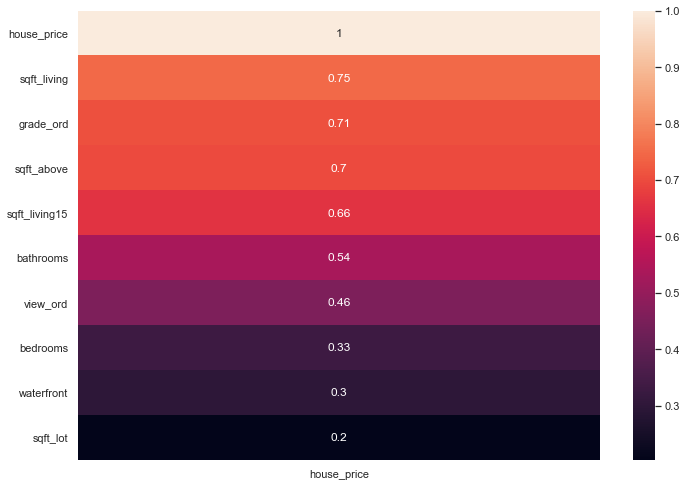

In [108]:
corr = seattle_corr.corr()[['house_price']].sort_values(by='house_price', ascending=False)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr, annot=True)